# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [2]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import ameritrade_functions as amc
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('IndHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['IND']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

2022-11-22 11:44:11,749|IndHoldingsAdjustement|INFO|Python version: 3.8.15
2022-11-22 11:44:11,751|IndHoldingsAdjustement|INFO|Pandas version: 1.5.1


In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-11-20 21:33:42,492|IndHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-11-20 21:33:43,702|IndHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-11-20 00:00:00|2022-11-18 00:00:00
2022-11-20 21:33:43,739|numexpr.utils|INFO|NumExpr defaulting to 4 threads.
2022-11-20 21:33:43,779|IndHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-11-20 21:33:43,779|IndHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-11-20 21:33:43,987|IndHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-11-20 21:33:44,006|IndHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.018
2022-11-20 21:33:44,007|IndHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.3
2022-11-20 21:33:44,008|IndHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-11-20 21:37:29,618|IndHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.85|501->427


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-11-20 21:37:29,661|IndHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|427
2022-11-20 21:37:29,714|IndHoldingsAdjustement|INFO|OPT_DATE|2022-11-18 00:00:00


2022-11-20 21:37:42,780|IndHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01323679


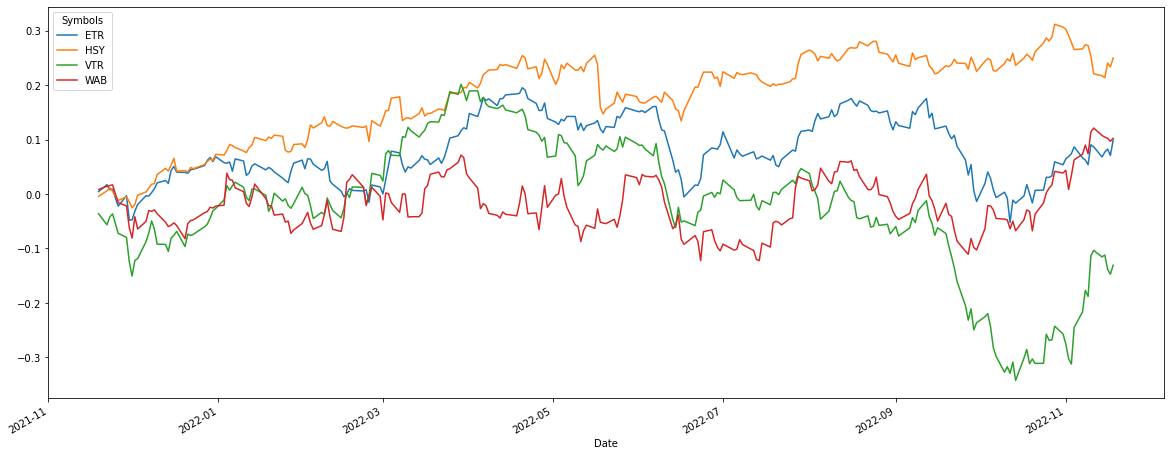

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-11-20 21:37:43,048|IndHoldingsAdjustement|INFO|STOCK|ETR                 |HOLDING|0.100000
2022-11-20 21:37:43,049|IndHoldingsAdjustement|INFO|STOCK|HSY                 |HOLDING|0.300000
2022-11-20 21:37:43,051|IndHoldingsAdjustement|INFO|STOCK|VTR                 |HOLDING|0.300000
2022-11-20 21:37:43,054|IndHoldingsAdjustement|INFO|STOCK|WAB                 |HOLDING|0.300000


In [10]:
import importlib
importlib.reload(amc)

<module 'ameritrade_functions' from 'c:\\users\\hp-z440\\anaconda projects\\svi-trading-tools\\tools\\ameritrade_functions.py'>

In [11]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,29364G103,ETR,Entergy Corporation Common Stock,NYSE,EQUITY,126.815,94.94,4.280,3.82,2022-11-10 00:00:00.000,...,4.93359,0.0,0.0,0.0,1.070,2022-12-01 00:00:00.000,0.62159,1121350.0,1121349.0,24871780.0
1,92276F100,VTR,"Ventas, Inc. Common Stock",NYSE,EQUITY,64.020,35.33,1.800,4.08,2022-09-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.450,2022-10-14 00:00:00.000,1.16199,2548040.0,2548037.0,46970510.0
2,929740108,WAB,Westinghouse Air Brake Technologies Corporatio...,NYSE,EQUITY,102.110,78.26,0.600,0.61,2022-11-10 00:00:00.000,...,18.88636,0.0,0.0,0.0,0.150,2022-11-28 00:00:00.000,1.49413,1043350.0,1043345.0,18500300.0
3,427866108,HSY,The Hershey Company Common Stock,NYSE,EQUITY,241.450,175.08,4.144,1.84,2022-11-17 00:00:00.000,...,29.29452,0.0,0.0,0.0,1.036,2022-12-15 00:00:00.000,0.35304,1312470.0,1312471.0,20067850.0


Tickers:   0%|          | 0/4 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/4 [00:00<?, ?News Table Items/s]

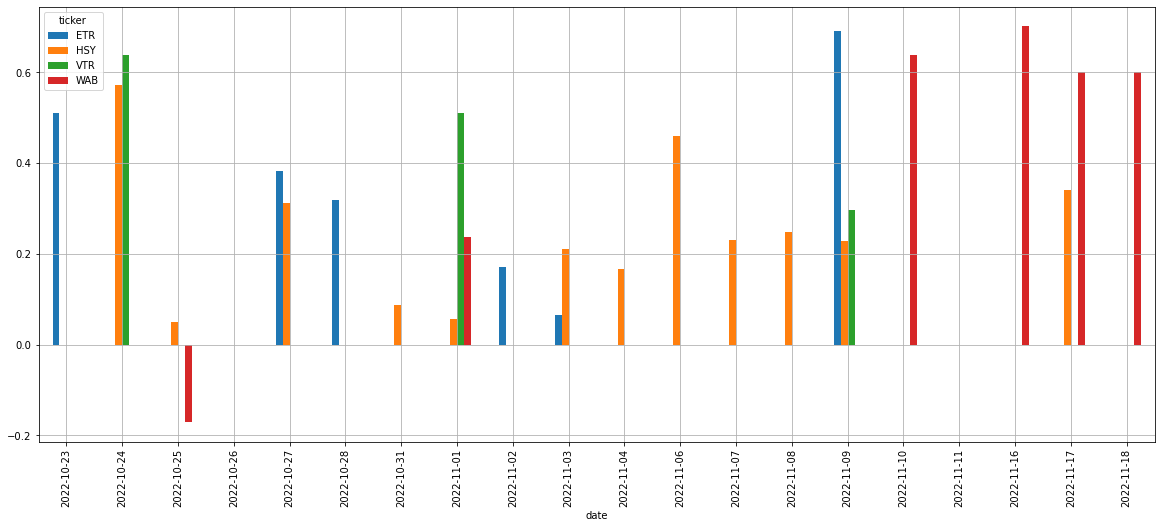

In [12]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [13]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    logger.error(f'Error: No authorization data: {td_ameritrade.authorization}')
    raise Exeption
else:
    logger.info('You have authorization')

2022-11-20 22:07:40,555|WDM|INFO|



====== WebDriver manager ======


2022-11-20 22:07:40,558|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-20 22:07:40,597|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-20 22:07:40,598|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-20 22:07:40,663|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
2022-11-20 22:08:19,895|IndHoldingsAdjustement|INFO|You have authorization


In [14]:
logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

2022-11-20 22:08:24,417|IndHoldingsAdjustement|INFO|TRADE_DATE|2022-11-20 22:08:24.417022
2022-11-20 22:08:26,701|IndHoldingsAdjustement|INFO|Full Equity Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---9216 JNJ               0.0     171.62000             0.0   
         RSG               0.0     132.26538             0.0   
         FISV              0.0     100.40059             0.0   
         IRM               0.0      52.11000             0.0   
         FGPHF             0.0       0.21397             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---9216 JNJ                      0.0                             0.0   
         RSG                      0.0                             0.0   
         FISV                     0.0                             0.0   
         IRM                      0.0                             0.0   
         FGPHF                    0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---9216 JNJ             10.0                 10.0                   0.0   
         RSG             13.0                 13.0                   0.0   
         FISV            17.0                 17.0                   0.0   
         IRM             11.0                 11.0                   0.0   
         FGPHF         5000.0               5000.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---9216 JNJ         1762.00                  528.60   
         RSG         1740.57                  522.17   
         FISV        1697.62                  509.29   
         IRM          575.30                  172.59   
         FGPHF        425.00                    0.00   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---9216 JNJ                            10.0    EQUITY  478160104           0   
         RSG                            13.0    EQUITY  760759100           0   
         FISV                           17.0    EQUITY  337738108           0   
         IRM                            11.0    EQUITY  46284V101           0   
         FGPHF                        5000.0    EQUITY  Q3860H107           0   

                type  
account  symbol       
#---9216 JNJ       0  
         RSG       0  
         FISV      0  
         IRM       0  
         FGPHF     0

In [15]:
total_portfolio_value = td_ameritrade.get_account_value(masked_account_number).round(2)
display(f'Account {masked_account_number} total value:  {total_portfolio_value}')

equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, 'EQUITY')
port_equi_values = td_ameritrade.get_market_values(masked_account_number, 'EQUITY')
display(port_equi_values)
total_equity_value = td_ameritrade.get_account_value(masked_account_number, 'EQUITY').round(2)
display(f'Account {masked_account_number} equity value: {total_equity_value}')

port_weights_equity = td_ameritrade.get_portfolio_weights(masked_account_number, 'EQUITY')
display(port_weights_equity*100)

'Account #---9216 total value:  6809.84'

account   symbol
#---9216  JNJ       1762.00
          RSG       1740.57
          FISV      1697.62
          IRM        575.30
          FGPHF      425.00
Name: marketValue, dtype: float64

'Account #---9216 equity value: 6200.49'

account   symbol
#---9216  FGPHF      6.854297
          FISV      27.378804
          IRM        9.278299
          JNJ       28.417109
          RSG       28.071491
Name: marketValue, dtype: float64

In [16]:
long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Stocks to sell:')
display(stocks_to_sell)

2022-11-20 22:08:38,336|IndHoldingsAdjustement|INFO|Stocks to sell:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---9216 JNJ               0.0     171.62000             0.0   
         RSG               0.0     132.26538             0.0   
         FISV              0.0     100.40059             0.0   
         IRM               0.0      52.11000             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---9216 JNJ                      0.0                             0.0   
         RSG                      0.0                             0.0   
         FISV                     0.0                             0.0   
         IRM                      0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---9216 JNJ             10.0                 10.0                   0.0   
         RSG             13.0                 13.0                   0.0   
         FISV            17.0                 17.0                   0.0   
         IRM             11.0                 11.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---9216 JNJ         1762.00                  528.60   
         RSG         1740.57                  522.17   
         FISV        1697.62                  509.29   
         IRM          575.30                  172.59   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---9216 JNJ                            10.0    EQUITY  478160104           0   
         RSG                            13.0    EQUITY  760759100           0   
         FISV                           17.0    EQUITY  337738108           0   
         IRM                            11.0    EQUITY  46284V101           0   

                type  
account  symbol       
#---9216 JNJ       0  
         RSG       0  
         FISV      0  
         IRM       0

### Submit and montior sell orders

In [17]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    logger.error(f'Error: No authorization data: {td_ameritrade.authorization}')
    raise Exeption
else:
    logger.info('You have authorization')

2022-11-20 22:09:11,176|WDM|INFO|



====== WebDriver manager ======


2022-11-20 22:09:11,178|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-20 22:09:11,218|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-20 22:09:11,220|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-20 22:09:11,294|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
2022-11-20 22:09:50,693|IndHoldingsAdjustement|INFO|You have authorization


In [18]:
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

Placing SELL order on #---9216 for 10.0 shares of JNJ...
Placed SELL order on #---9216 for 10.0 shares of JNJ
Placing SELL order on #---9216 for 13.0 shares of RSG...
Placed SELL order on #---9216 for 13.0 shares of RSG
Placing SELL order on #---9216 for 17.0 shares of FISV...
Placed SELL order on #---9216 for 17.0 shares of FISV
Placing SELL order on #---9216 for 11.0 shares of IRM...
Placed SELL order on #---9216 for 11.0 shares of IRM


In [ ]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


In [19]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

2022-11-21 09:47:11,090|WDM|INFO|



====== WebDriver manager ======


2022-11-21 09:47:11,097|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-21 09:47:11,134|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-21 09:47:11,135|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-21 09:47:11,241|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


initialBalances_cashBalance           0.000000
initialBalances_totalCash             0.000000
initialBalances_equity             6384.930000
initialBalances_moneyMarketFund     609.440000
currentBalances_cashBalance        5779.020000
currentBalances_equity             6388.460000
currentBalances_moneyMarketFund     609.440000
current_return                        0.000553
Name: #---9216, dtype: float64

5779.02
609.44
2022-11-21 09:47:50,814|IndHoldingsAdjustement|INFO|INVESTMENT_AMT|6388.460000000001


In [20]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 6388.460000000001
Amount to invest: 6000


In [21]:
long_weights

,optimalWeights
ETR,0.1
HSY,0.3
VTR,0.3
WAB,0.3


In [22]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-11-21 09:48:02.373127
Initial investment amount: 6000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
ETR,111.92,0.1,600.0,5
HSY,225.21,0.3,1800.0,7
VTR,44.07,0.3,1800.0,40
WAB,99.16,0.3,1800.0,18


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
ETR,111.92,0.1,600.0,5,559.60
HSY,225.21,0.3,1800.0,7,1576.47
VTR,44.07,0.3,1800.0,40,1762.80
WAB,99.16,0.3,1800.0,18,1784.88


Total cost: 5683.75


### Place buy orders

In [23]:
amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,29364G103,ETR,Entergy Corporation Common Stock,NYSE,EQUITY,126.815,94.94,4.280,3.82,2022-11-10 00:00:00.000,...,4.93359,0.0,0.0,0.0,1.070,2022-12-01 00:00:00.000,0.62159,1121350.0,1121349.0,24871780.0
1,92276F100,VTR,"Ventas, Inc. Common Stock",NYSE,EQUITY,64.020,35.33,1.800,4.08,2022-09-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.450,2022-10-14 00:00:00.000,1.16199,2548040.0,2548037.0,46970510.0
2,929740108,WAB,Westinghouse Air Brake Technologies Corporatio...,NYSE,EQUITY,102.110,78.26,0.600,0.61,2022-11-10 00:00:00.000,...,18.88636,0.0,0.0,0.0,0.150,2022-11-28 00:00:00.000,1.49413,1043350.0,1043345.0,18500300.0
3,427866108,HSY,The Hershey Company Common Stock,NYSE,EQUITY,241.450,175.08,4.144,1.84,2022-11-17 00:00:00.000,...,29.29452,0.0,0.0,0.0,1.036,2022-12-15 00:00:00.000,0.35304,1312470.0,1312471.0,20067850.0


In [24]:
print(datetime.today())
#td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
#td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-11-21 09:48:37.270289
Placing BUY order on 755579216 for 5.0 shares of ETR:EQUITY...
Placed BUY order on #---9216 for 5.0 shares of ETR
Placing BUY order on 755579216 for 7.0 shares of HSY:EQUITY...
Placed BUY order on #---9216 for 7.0 shares of HSY
Placing BUY order on 755579216 for 40.0 shares of VTR:EQUITY...
Placed BUY order on #---9216 for 40.0 shares of VTR
Placing BUY order on 755579216 for 18.0 shares of WAB:EQUITY...
Placed BUY order on #---9216 for 18.0 shares of WAB


In [ ]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]